In [1]:
%reload_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from tqdm import tqdm

%aimport -plt
%aimport -np
%aimport -glob
%aimport -cv2

from os import listdir
from os.path import isfile, join

%matplotlib inline

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import car_detection
print(dir(car_detection))
from car_detection import log_progress
import builtins
from IPython.lib import deepreload


['Undistorter', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'bg', 'cv2', 'extract_hog_features', 'feature_extractor', 'fun', 'get_features', 'get_hog_features', 'hog', 'hog_extractor', 'isfile', 'join', 'listdir', 'log_progress', 'math', 'multiprocessing', 'np', 'parmap', 'quickpool', 'sliding_window', 'undistorter']


In [2]:
undistorter = car_detection.Undistorter.load_from_path('./camera_cal')

In [3]:
test_path = '.\\test_images'
test_imgs = [cv2.imread(join(test_path, f)) for f in listdir(test_path) if isfile(join(test_path, f))]
undistorted_images = []

for img in test_imgs:
    print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = undistorter.undistort(img)
    undistorted_images.append(dst)

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


In [4]:
def find_pictures(path):
    pictures = []
    for f in listdir(path):
        joined_path = join(path, f)
        if isfile(joined_path):
            pictures.append(joined_path)
        else:
            pictures.extend(find_pictures(joined_path))
    return pictures

def load_pictures(paths):
    def load_pic(path):
        img = cv2.imread(path)
        if img is not None:
            return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return None
    return [r for r in (load_pic(path) for path in log_progress(paths)) if r is not None]

In [5]:
vehicle_pictures = load_pictures(find_pictures('.\\training_data\\vehicles'))

255


In [6]:
nonvehicle_pictures = load_pictures(find_pictures('.\\training_data\\non-vehicles'))

In [7]:
vehicle_labels = len(vehicle_pictures) * [True]
nonvehicle_labels = len(nonvehicle_pictures) * [False]

total_pictures = np.concatenate((vehicle_pictures, nonvehicle_pictures))
total_labels = np.concatenate((vehicle_labels, nonvehicle_labels))

print("vehicle_labels Count:", len(vehicle_labels))
print("nonvehicle_labels Count:", len(nonvehicle_labels))
print("Total Count:", len(total_labels))

vehicle_labels Count: 8792
nonvehicle_labels Count: 8968
Total Count: 17760


In [8]:
from collections import Counter
print(Counter([img.shape for img in total_pictures]))
# All the same size, RGB 64x64

Counter({(64, 64, 3): 17760})


In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

total_pictures, total_labels = shuffle(total_pictures, total_labels)

In [10]:
def show_image(img, title=''):
    fig = plt.figure(figsize=(20,20))
    plt.imshow(img)
    fig.suptitle(title)

In [11]:
# def get_features(img):
#     features = car_detection.extract_hog_features(img, hog_channel='ALL')
#     return features

# def get_features_from_images(images):
#     return [get_features(img) for img in images]


In [12]:
print(len(total_pictures))
print(dir(car_detection))
func = car_detection.get_features
#total_picture_features = car_detection.parmap(func, total_pictures)
total_picture_features = [car_detection.get_features(img) for img in total_pictures]

17760
['Undistorter', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'bg', 'cv2', 'extract_hog_features', 'feature_extractor', 'fun', 'get_features', 'get_hog_features', 'hog', 'hog_extractor', 'isfile', 'join', 'listdir', 'log_progress', 'math', 'multiprocessing', 'np', 'parmap', 'quickpool', 'sliding_window', 'undistorter']


In [13]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(total_picture_features)

total_picture_features_scaled = X_scaler.transform(total_picture_features)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(total_picture_features_scaled, total_labels, test_size=0.25)

In [15]:
from sklearn.svm import LinearSVC
import time

svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
print(X_train.shape)
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

(13320, 5292)
22.49 Seconds to train SVC...
Test Accuracy of SVC =  0.9865
My SVC predicts:  [ True  True False False  True False  True False False  True]
For these 10 labels:  [ True  True False False  True False  True False False  True]
0.0155 Seconds to predict 10 labels with SVC


sucess
sucess
sucess


Counter({False: 4419, True: 102})


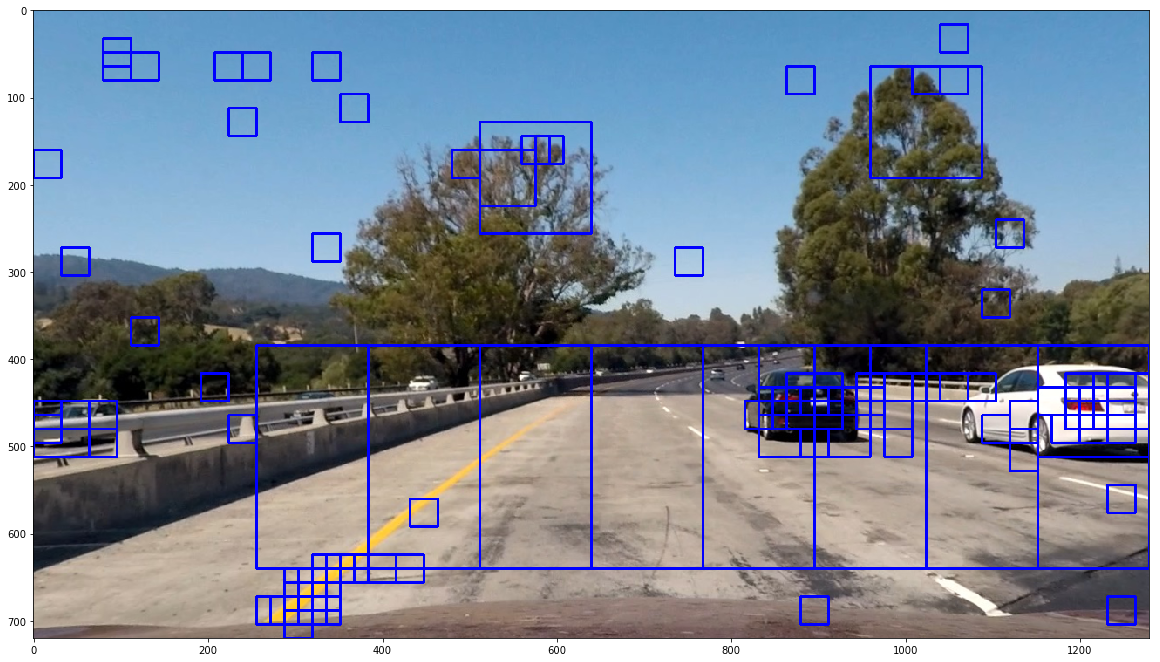

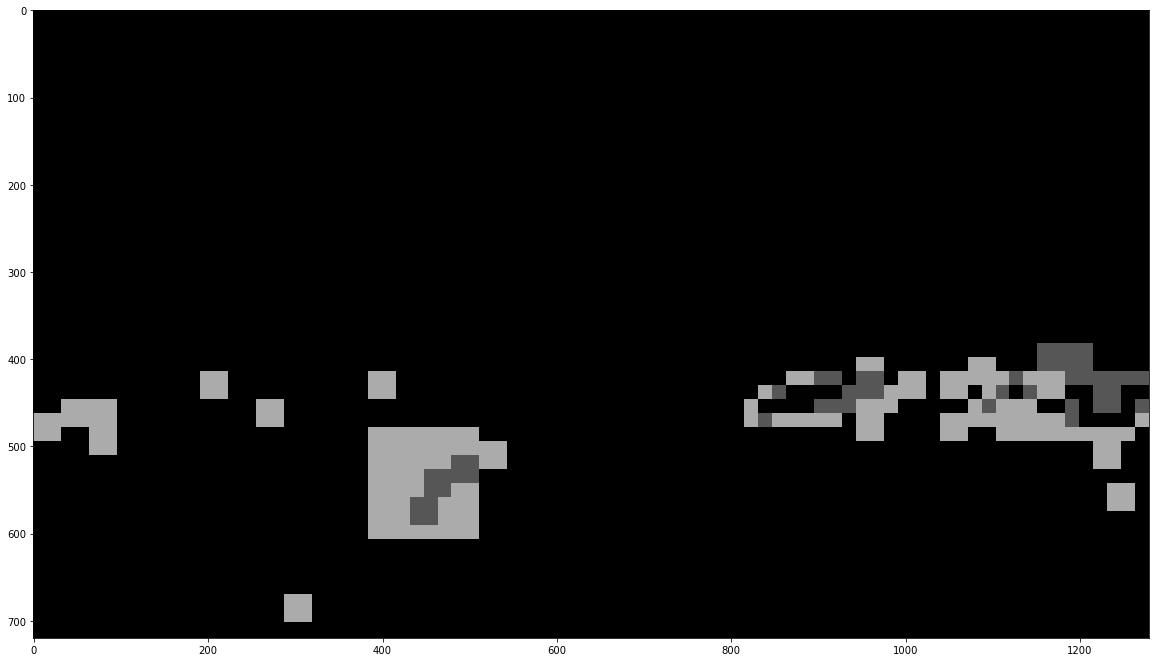

In [39]:
def build_heatmap(orig_img):
    windows =[]
    window_sizes = [(64,64), (32,32),(128,128)]
    for window_size in window_sizes:
        windows.extend(car_detection.sliding_window(orig_img, y_start_stop=[350, None],
                                                              xy_window=window_size,xy_overlap=(0.5, 0.5)))

    matching_boxes = []
    results = []

    heat_map = np.zeros_like(orig_img)

    result_windows = []
    for window in log_progress(windows):
        test_img = cv2.resize(orig_img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      

        img_features = car_detection.get_features(test_img)
        img_features = X_scaler.transform([img_features])[0]
        if len(img_features) == 5292:
            result = svc.predict([img_features])[0]
            results.append(result)
            if result:
                result_windows.append(window)
                heat_map[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
                cv2.rectangle(orig_img, window[0], window[1],color=(0,0,255),thickness=2)
        else:
            print("Nope")
            print(len(img_features))
    return heat_map

heat_map = build_heatmap(undistorted_images[0].copy())

show_image(orig_img)
show_image(heat_map*(255/np.max(heat_map)))

print(Counter(results))

3 cars found
int32


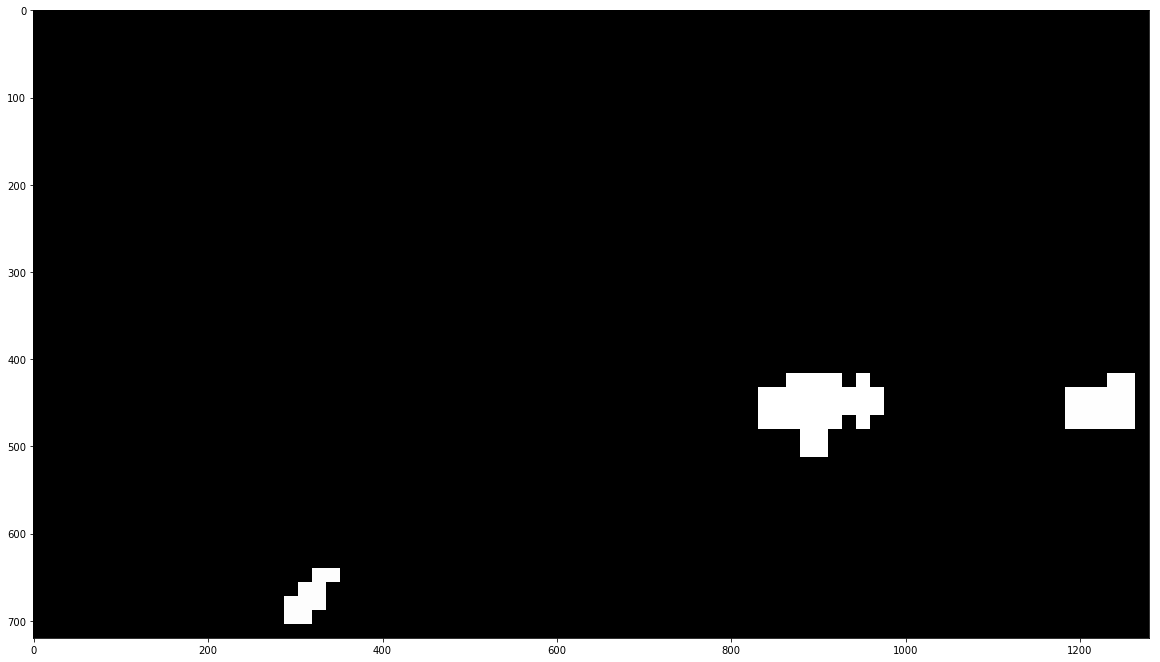

In [29]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


from scipy.ndimage.measurements import label
heat_map = apply_threshold(heat_map, 3)
labels = label(heat_map)
print(labels[1], 'cars found')
print(labels[0].dtype)
show_image(labels[0].astype(np.float32))
#plt.imshow(labels[0], cmap='gray')

In [42]:
from moviepy.editor import VideoFileClip, clips_array

def handle_image(image):
    heat_map = build_heatmap(image)
    heat_map = apply_threshold(heat_map, 3)
    labels = label(heat_map)
    return labels[0]

def run_video(input, output):
    clip2 = VideoFileClip(input)
    yellow_clip = clip2.fl_image(handle_image)
    %time yellow_clip.write_videofile(output, audio=False)
    del yellow_clip

def run_test_video(input, output):
    print(input)
    clip1 = VideoFileClip(input).subclip(0,0.03)
    result_clip = clip1.fl_image(handle_image)
    %time result_clip.write_videofile(output, audio=False)
    del result_clip
input = './test_video.mp4'
output = './test_video_outcome_8.mp4'
try:
    run_video(input, output)
    #run_test_video(input, output)
except Exception as e: 
    raise e

sucess
sucess
sucess


[MoviePy] >>>> Building video ./test_video_outcome_8.mp4
[MoviePy] Writing video ./test_video_outcome_8.mp4


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

sucess
sucess
sucess


 33%|████████████████████████████                                                        | 1/3 [00:13<00:26, 13.14s/it]

sucess
sucess
sucess


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:26<00:13, 13.18s/it]

sucess
sucess
sucess


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:39<00:00, 13.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_outcome_8.mp4 

Wall time: 39.6 s


In [47]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from skimage.feature import hog

orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32

#img = mpimg.imread('test_image.jpg')
img = undistorted_images[0].copy()

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

ValueError: operands could not be broadcast together with shapes (1,8460) (5292,) (1,8460) 

In [59]:
def get_features(img):    
    ctrans_tosearch = convert_color(img, conv='RGB2YCrCb')

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
    
    hog_features = np.hstack((hog1, hog2, hog3))
    
    spatial_features = bin_spatial(img, size=spatial_size)
    hist_features = color_hist(img, nbins=hist_bins)
    
    return np.hstack((spatial_features, hist_features, hog_features))
              
total_picture_features = [get_features(img) for img in log_progress(total_pictures)]


In [60]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(total_picture_features)

total_picture_features_scaled = X_scaler.transform(total_picture_features)

X_train, X_test, y_train, y_test = train_test_split(total_picture_features_scaled, total_labels, test_size=0.25)



In [61]:
from sklearn.svm import LinearSVC
import time

svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
print(X_train.shape)
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

(13320, 8460)
10.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9926
My SVC predicts:  [False False False False False  True False False False False]
For these 10 labels:  [False False False False False  True False False False False]
0.01448 Seconds to predict 10 labels with SVC


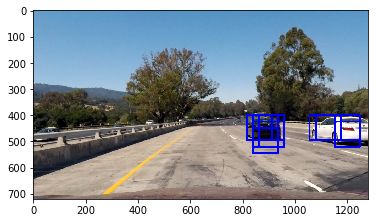

In [63]:
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

def find_cars_func(img):
    return find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

In [64]:
from moviepy.editor import VideoFileClip, clips_array

def handle_image(image):
    heat_map = build_heatmap(image)
    heat_map = apply_threshold(heat_map, 3)
    labels = label(heat_map)
    return labels[0]

def run_video(input, output):
    clip2 = VideoFileClip(input)
    yellow_clip = clip2.fl_image(find_cars_func)
    %time yellow_clip.write_videofile(output, audio=False)
    del yellow_clip

def run_test_video(input, output):
    print(input)
    clip1 = VideoFileClip(input).subclip(0,0.03)
    result_clip = clip1.fl_image(handle_image)
    %time result_clip.write_videofile(output, audio=False)
    del result_clip
    
input = './test_video.mp4'
output = './test_video_outcome_8.mp4'
try:
    run_video(input, output)
    #run_test_video(input, output)
except Exception as e: 
    raise e

[MoviePy] >>>> Building video ./test_video_outcome_8.mp4
[MoviePy] Writing video ./test_video_outcome_8.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:28<00:00,  1.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_outcome_8.mp4 

Wall time: 29 s
